In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time

The following link provides the number of the observed scanned receipts each day for the year 2021. Based on this prior knowledge, please develop an algorithm which can predict the approximate number of the scanned receipts for each month of 2022.

In [86]:
data = pd.read_csv('./data_daily.csv', dtype= {
    '# Date': str,
    'Receipt_Count': int
})

In [40]:
len(data)

365

In [87]:
def split_data(receipt, length):
    data_raw = receipt.to_numpy() # convert to numpy array
    data = []

    print(len(data_raw))
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - length + 1): 
        data.append(data_raw[index: index + length])
    
    data = np.array(data)
    print(len(data))

    x_train = data[:,:-1,:]
    y_train = data[:,-1,:]

    return [x_train, y_train]



In [88]:
scaler = MinMaxScaler(feature_range=(-1,1))
receipt = data[['Receipt_Count']]
receipt['Receipt_Count'] = scaler.fit_transform(receipt['Receipt_Count'].values.reshape(-1,1))

/var/folders/gy/xbhp1f1d7kd3r6bppxqbmk780000gn/T/ipykernel_72756/1840372422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  receipt['Receipt_Count'] = scaler.fit_transform(receipt['Receipt_Count'].values.reshape(-1,1))


In [89]:
x_train, y_train = split_data(receipt, 30)

365
336


In [90]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)

In [91]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [92]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [93]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [94]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.15665322542190552
Epoch  1 MSE:  0.14901340007781982
Epoch  2 MSE:  0.13044019043445587
Epoch  3 MSE:  0.10658635199069977
Epoch  4 MSE:  0.06119229644536972
Epoch  5 MSE:  0.025348398834466934
Epoch  6 MSE:  0.08095266669988632
Epoch  7 MSE:  0.017237573862075806
Epoch  8 MSE:  0.027275392785668373
Epoch  9 MSE:  0.041248079389333725
Epoch  10 MSE:  0.045392684638500214
Epoch  11 MSE:  0.04375758022069931
Epoch  12 MSE:  0.03829992562532425
Epoch  13 MSE:  0.02962288074195385
Epoch  14 MSE:  0.02020012028515339
Epoch  15 MSE:  0.018456673249602318
Epoch  16 MSE:  0.026476019993424416
Epoch  17 MSE:  0.026311131194233894
Epoch  18 MSE:  0.026176759973168373
Epoch  19 MSE:  0.02408275194466114
Epoch  20 MSE:  0.019098851829767227
Epoch  21 MSE:  0.01674707792699337
Epoch  22 MSE:  0.018862923607230186
Epoch  23 MSE:  0.021626323461532593
Epoch  24 MSE:  0.021756315603852272
Epoch  25 MSE:  0.020213846117258072
Epoch  26 MSE:  0.018933216109871864
Epoch  27 MSE:  0.01831

In [95]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

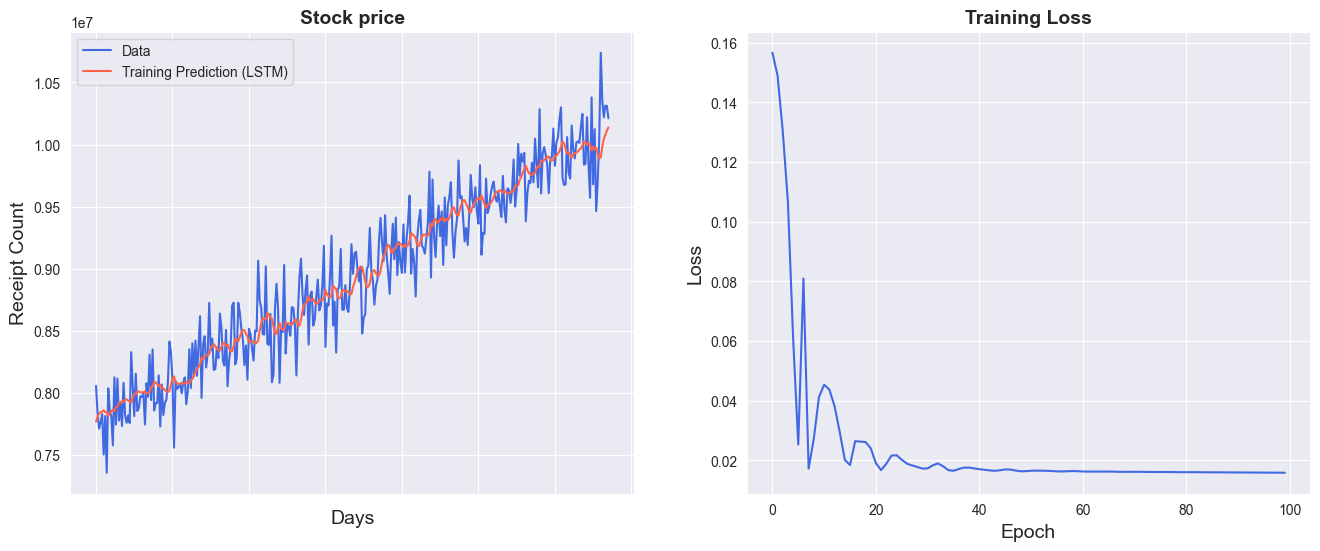

In [96]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Receipt Count", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

tensor([[0.7103]])

In [127]:
start = torch.cat((x_train[-1][1:], y_train_lstm[-1].unsqueeze(1)), 0) 

In [131]:
start.unsqueeze(1).shape

torch.Size([29, 1, 1])

In [124]:
dates = data['# Date'].values

In [133]:
predictions = []
for i in range(len(dates)):
    y_pred = model(start.unsqueeze(1))
    predictions.append(y_pred)
    start = torch.cat((start[1:], y_pred[-1].unsqueeze(1)), 0) 
    


In [137]:
daily_predict = []
for pred in predictions:
    trans = scaler.inverse_transform(pred.detach().numpy())
    daily_predict.append(trans)

In [143]:
days = [31,28,31,30,31,30,31,31,30,31,30,31]

In [145]:

monthly_predict = []
for i in range(12):
    s = sum(days[:i])
    offset = days[i]
    cnt = sum(daily_predict[s:s+offset])
    monthly_predict.append(cnt)


    


In [148]:
Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [157]:
monthly_predict

[array([[2.7657680e+08],
        [2.7648045e+08],
        [2.7634282e+08],
        [2.7623629e+08],
        [2.7613456e+08],
        [2.7598717e+08],
        [2.7586013e+08],
        [2.7574093e+08],
        [2.7560806e+08],
        [2.7547424e+08],
        [2.7534173e+08],
        [2.7519514e+08],
        [2.7503773e+08],
        [2.7492400e+08],
        [2.7480941e+08],
        [2.7465478e+08],
        [2.7454138e+08],
        [2.7445642e+08],
        [2.7428506e+08],
        [2.7418835e+08],
        [2.7404397e+08],
        [2.7397075e+08],
        [2.7387152e+08],
        [2.7373549e+08],
        [2.7352682e+08],
        [2.7335853e+08],
        [2.7320403e+08],
        [2.7303962e+08],
        [2.7287549e+08]], dtype=float32),
 array([[2.4631254e+08],
        [2.4631235e+08],
        [2.4631232e+08],
        [2.4631232e+08],
        [2.4631232e+08],
        [2.4631232e+08],
        [2.4631232e+08],
        [2.4631232e+08],
        [2.4631232e+08],
        [2.4631232e+08],
        

In [156]:
sum([num[0] for num in monthly_predict])[0] - data['Receipt_Count'].sum()

-6965345.0

3221696609

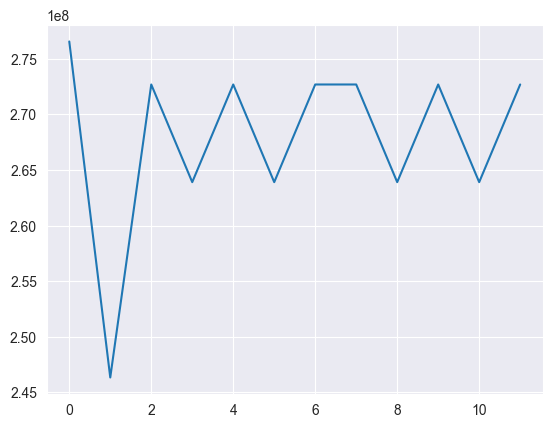

In [152]:
fig = plt.figure()
plt.plot([num[0] for num in monthly_predict])

In [72]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [73]:
model2 = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion2 = torch.nn.MSELoss(reduction='mean')
optimiser2 = torch.optim.Adam(model2.parameters(), lr=0.01)

In [74]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model2(x_train)

    loss = criterion2(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser2.zero_grad()
    loss.backward()
    optimiser2.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.18536277115345
Epoch  1 MSE:  0.13148947060108185
Epoch  2 MSE:  0.09152736514806747
Epoch  3 MSE:  0.043469540774822235
Epoch  4 MSE:  0.0304122231900692
Epoch  5 MSE:  0.053494472056627274
Epoch  6 MSE:  0.02978287637233734
Epoch  7 MSE:  0.018478674814105034
Epoch  8 MSE:  0.02199290692806244
Epoch  9 MSE:  0.026619859039783478
Epoch  10 MSE:  0.03027086704969406
Epoch  11 MSE:  0.02960723638534546
Epoch  12 MSE:  0.024594746530056
Epoch  13 MSE:  0.01927955262362957
Epoch  14 MSE:  0.017459513619542122
Epoch  15 MSE:  0.018624430522322655
Epoch  16 MSE:  0.02053130604326725
Epoch  17 MSE:  0.022240154445171356
Epoch  18 MSE:  0.021280670538544655
Epoch  19 MSE:  0.017959268763661385
Epoch  20 MSE:  0.016185324639081955
Epoch  21 MSE:  0.01692802645266056
Epoch  22 MSE:  0.018187804147601128
Epoch  23 MSE:  0.018730800598859787
Epoch  24 MSE:  0.01868925802409649
Epoch  25 MSE:  0.01822708174586296
Epoch  26 MSE:  0.017246372997760773
Epoch  27 MSE:  0.0161203835159

In [75]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

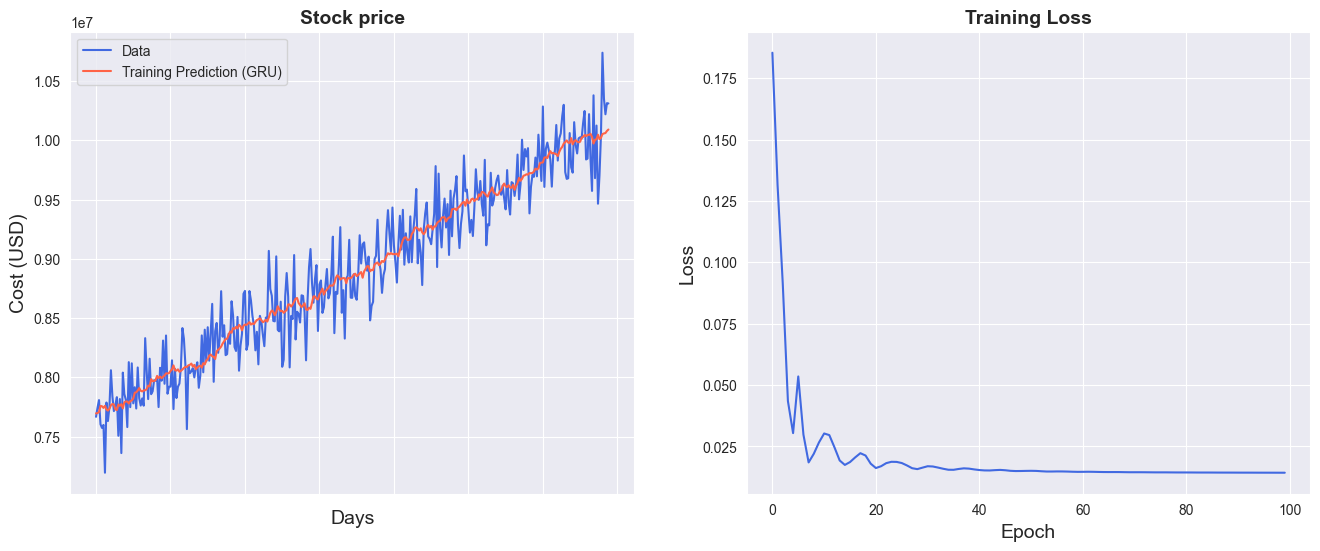

In [76]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)